<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 6.5
## Feature Selection

### Data

**Predict the onset of diabetes based on diagnostic measures.**

This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

[Pima Indians Diabetes Database](https://www.kaggle.com/uciml/pima-indians-diabetes-database/download)

In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### 1. Load Data

In [3]:
# Read Data
diabetes_csv = 'diabetes.csv'
df = pd.read_csv(diabetes_csv)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


#### 2. Perform EDA

Perform EDA. Check Null Values. Impute if necessary.

In [7]:
# Check the null number
print(df.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


In [9]:
# Check the data
df.shape

(768, 9)

In [11]:
# Check the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


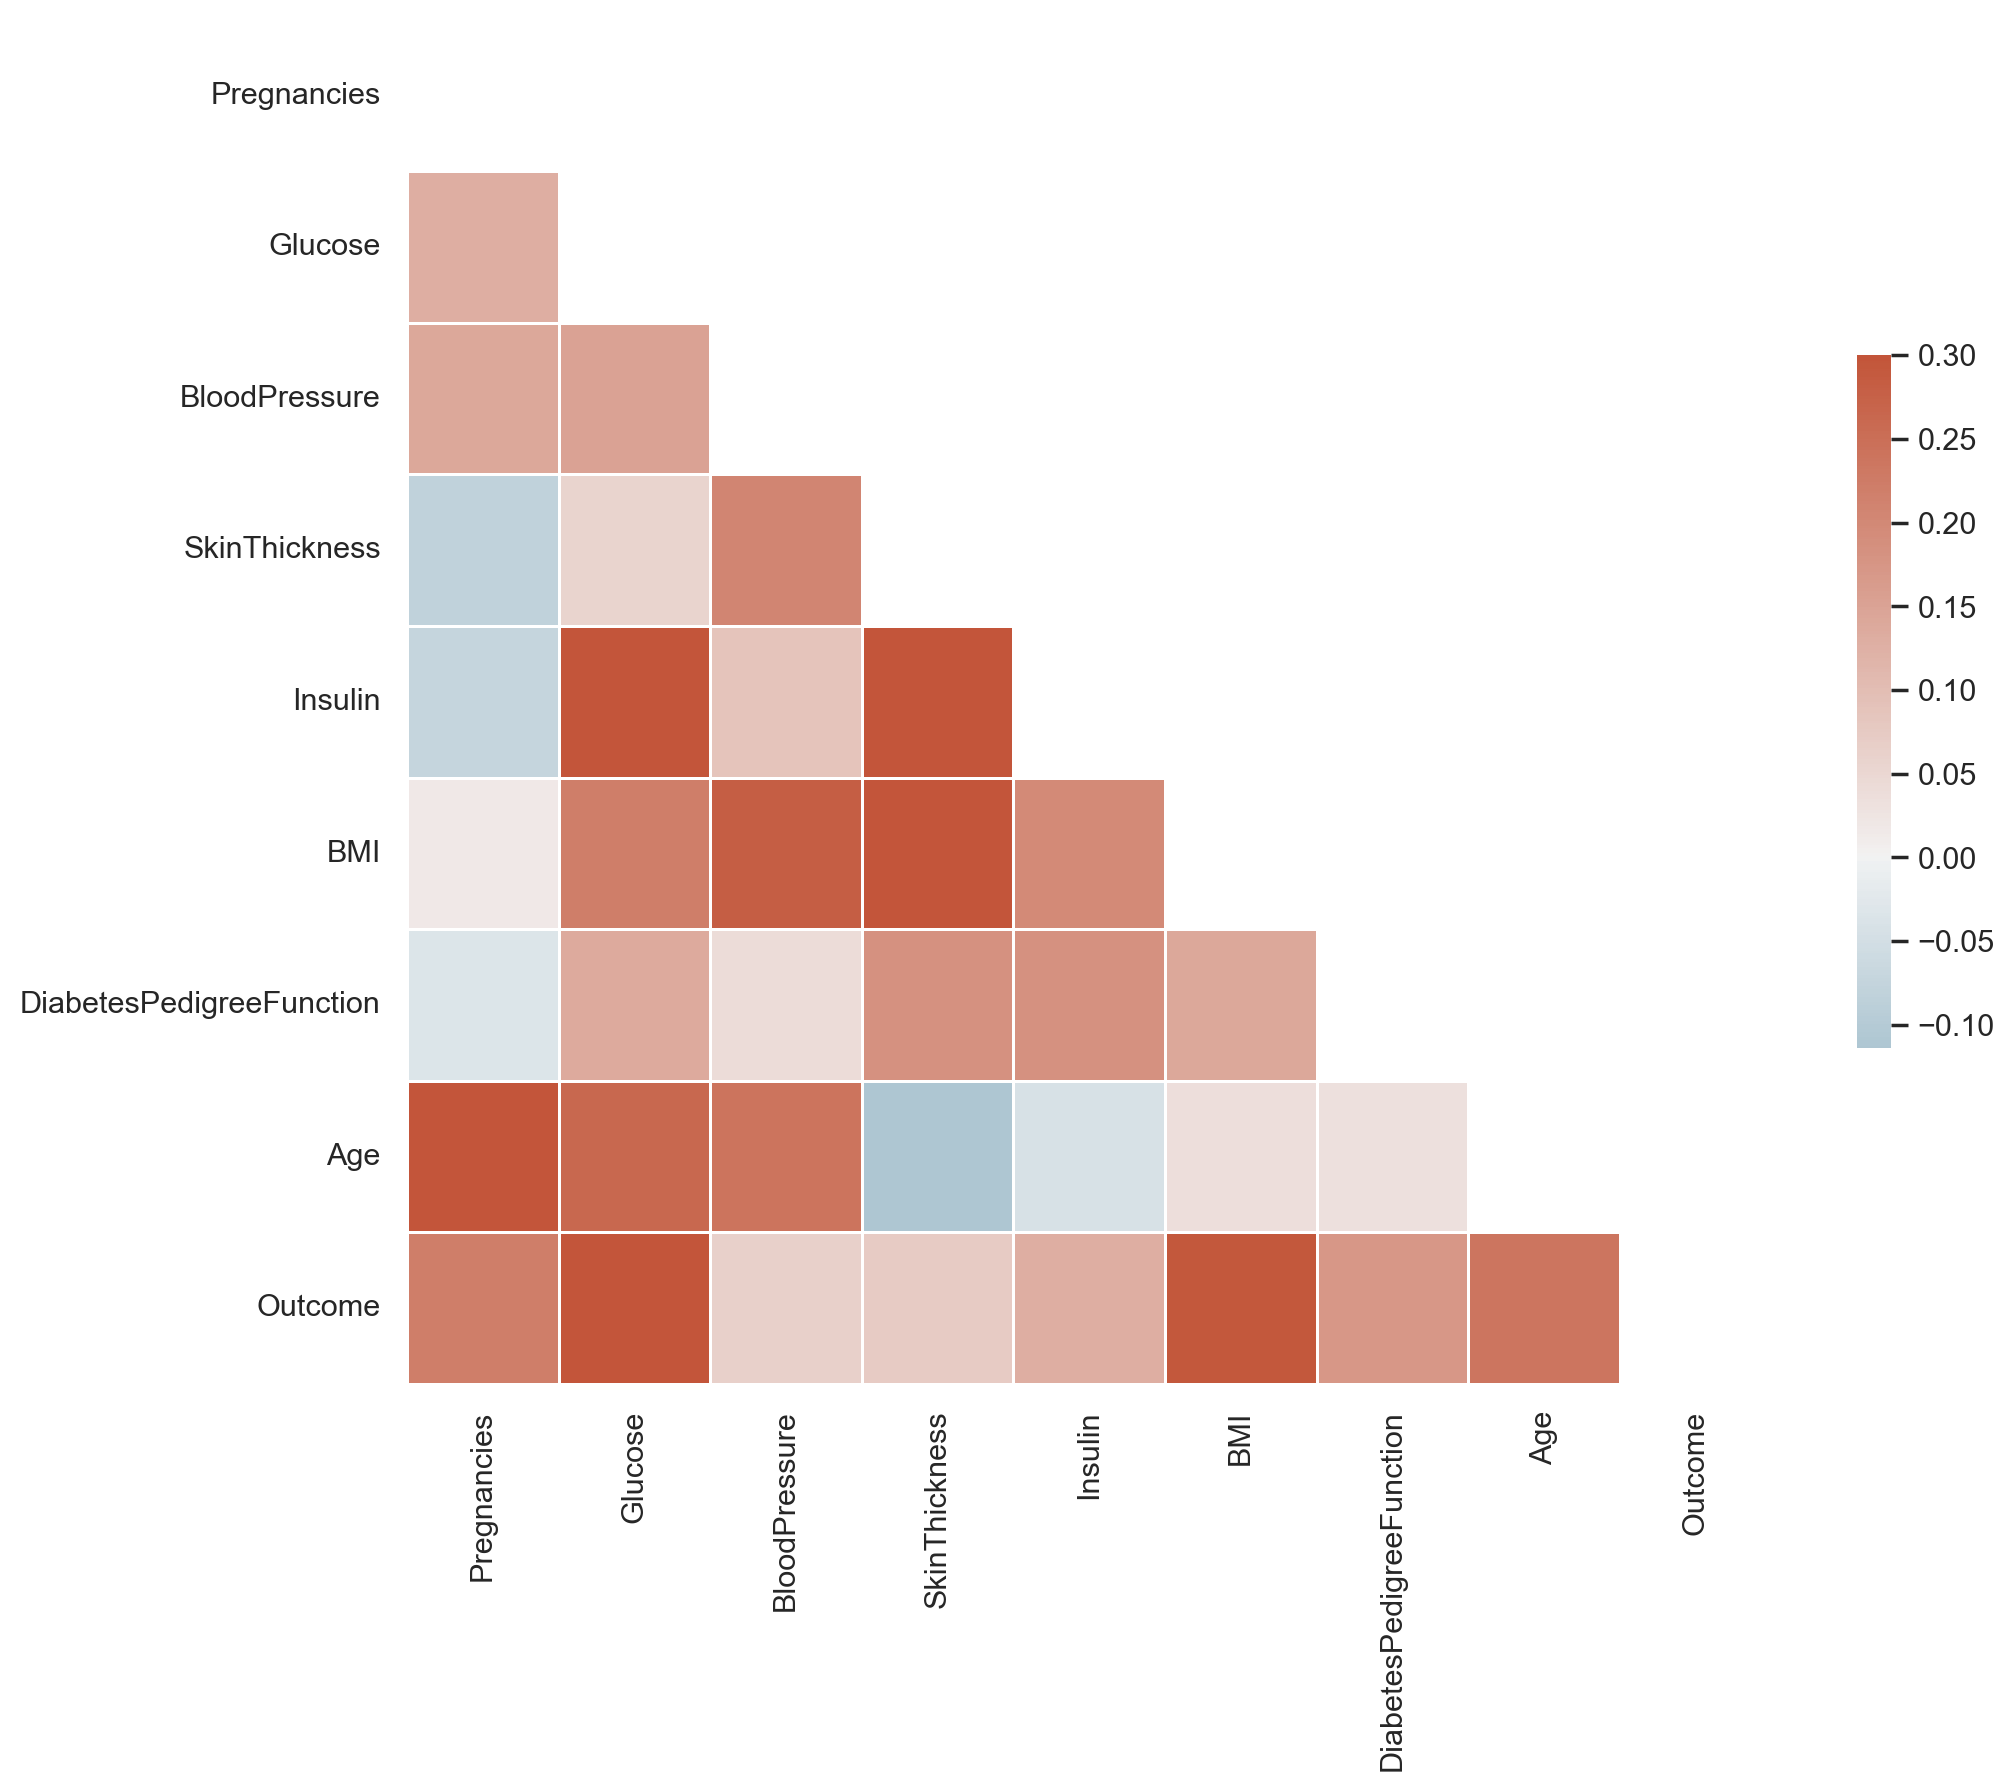

In [13]:
# Check the correlation
# Check the correlation of numerical variables
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)
d = pd.DataFrame(data=rs.normal(size=(100, 26)),
                 columns=list(ascii_letters[26:]))

# Compute the correlation matrix
corr = df.corr(numeric_only = True)

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

#### 3. Set Target

- Set `Outcome` as target.
- Set Features

In [16]:
# Define 'Outcome' as target variables
y = df['Outcome']
X =df.drop('Outcome', axis = 1)

#### 4. Select Feature

The classes in the sklearn.feature_selection module can be used for feature selection/dimensionality reduction on sample sets, either to improve estimators’ accuracy scores or to boost their performance on very high-dimensional datasets.

##### 4.1 Univariate Selection

Univariate feature selection works by selecting the best features based on univariate statistical tests. It can be seen as a preprocessing step to an estimator. Scikit-learn exposes feature selection routines as objects that implement the transform method:

- SelectKBest removes all but the  highest scoring features
- Use sklearn.feature_selection.chi2 as score function
    > Recall that the chi-square test measures dependence between stochastic variables, so using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.


More Reads:
[Univariate feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)

- Create an instance of SelectKBest
    - Use sklearn.feature_selection.chi2 as score_func
    - Use k of your choice
- Fit X, y
- Find top 4 features
- Transform features to a DataFrame

In [19]:
# Create an instance of SelectKBest
k = 4  # choose number of top features
selector = SelectKBest(score_func=chi2, k=k)

In [21]:
# Fit
selector.fit(X, y)

SelectKBest(k=4, score_func=<function chi2 at 0x00000140BB3B4860>)

In [23]:
# Print Score
# Create a DataFrame with feature scores
scores_df = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': selector.scores_
}).sort_values(by='Chi2 Score', ascending=False)

print("Chi² Scores for all features:")
print(scores_df)

# Find Top 4 Features
top_4 = scores_df.head(4)['Feature'].values
print("\nTop 4 features:", top_4)

Chi² Scores for all features:
                    Feature   Chi2 Score
4                   Insulin  2175.565273
1                   Glucose  1411.887041
7                       Age   181.303689
5                       BMI   127.669343
0               Pregnancies   111.519691
3             SkinThickness    53.108040
2             BloodPressure    17.605373
6  DiabetesPedigreeFunction     5.392682

Top 4 features: ['Insulin' 'Glucose' 'Age' 'BMI']


In [25]:
# Transform X to Features
X_selected = selector.transform(X)

# Get selected feature names
selected_feature_names = X.columns[selector.get_support()]

In [31]:
# Transform features to a dataframe
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)
print("\nTransformed DataFrame:")
print(X_selected_df.head())


Transformed DataFrame:
   Glucose  Insulin   BMI   Age
0    148.0      0.0  33.6  50.0
1     85.0      0.0  26.6  31.0
2    183.0      0.0  23.3  32.0
3     89.0     94.0  28.1  21.0
4    137.0    168.0  43.1  33.0


##### 4.2 Recursive feature elimination

Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute. Then, the least important features are pruned from current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

More Reads:
[Recursive feature elimination](https://scikit-learn.org/stable/modules/feature_selection.html)

- Use RFE to extract feature
    - use LogisticRegression as estimator
    - Number of n_features_to_select as of your choice
- Fit X, y to RFE
- Find Selected Features

In [33]:
# Create estimator (Logistic Regression) and RFE selector
model = LogisticRegression(max_iter=1000)
selector = RFE(estimator=model, n_features_to_select=4)

In [35]:
# Fit the selector with X and y
selector.fit(X,y)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=4)

In [37]:
# Print Score
# Create a DataFrame with feature ranking
ranking_df = pd.DataFrame({
    'Feature': X.columns,
    'Selected': selector.support_,
    'Ranking': selector.ranking_
}).sort_values(by='Ranking')

# Get top 4 features (ranking = 1)
top_features = ranking_df[ranking_df['Selected']]['Feature'].tolist()

# Print results
print("RFE Feature Ranking:\n", ranking_df)
print("\nTop 4 Selected Features:", top_features)

RFE Feature Ranking:
                     Feature  Selected  Ranking
0               Pregnancies      True        1
1                   Glucose      True        1
5                       BMI      True        1
6  DiabetesPedigreeFunction      True        1
7                       Age     False        2
2             BloodPressure     False        3
4                   Insulin     False        4
3             SkinThickness     False        5

Top 4 Selected Features: ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction']


In [39]:
# Transform X to Features
X_selected = selector.transform(X)

# Get selected feature names
selected_feature_names = X.columns[selector.get_support()]

In [41]:
# Transform features to a dataframe
X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)
print("\nTransformed DataFrame:")
print(X_selected_df.head())


Transformed DataFrame:
   Pregnancies  Glucose   BMI  DiabetesPedigreeFunction
0          6.0    148.0  33.6                     0.627
1          1.0     85.0  26.6                     0.351
2          8.0    183.0  23.3                     0.672
3          1.0     89.0  28.1                     0.167
4          0.0    137.0  43.1                     2.288




---



---



> > > > > > > > > © 2025 Institute of Data


---



---



